# Lab 2. Multimadal

In [1]:
import requests
from pathlib import Path

In [2]:
if not Path("ov_phi3_vision.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/phi-3-vision/ov_phi3_vision.py")
    open("ov_phi3_vision.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

### Convert and Compress Phi-3.5-vision model

In [3]:
from pathlib import Path
import nncf
from modelscope import snapshot_download
from ov_phi3_vision import convert_phi3_model

llm_model_id = "LLM-Research/Phi-3.5-vision-instruct"
ori_llm_model_path = "./model/Phi-3.5-vision-instruct-pytorch"
llm_model_path = "./model/Phi-3.5-vision-instruct-ov"
llm_local_path = ori_llm_model_path + "/LLM-Research/Phi-3___5-vision-instruct"

compression_configuration = {
    "mode": nncf.CompressWeightsMode.INT4_SYM,
    "group_size": 64,
    "ratio": 0.6,
}

if not Path(llm_model_path).exists():
    if not Path(ori_llm_model_path).exists():
        model_dir = snapshot_download(llm_model_id, cache_dir=ori_llm_model_path)
    convert_phi3_model(llm_local_path, llm_model_path, compression_configuration)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino
⌛ Phi-3-vision conversion started. Be patient, it may takes some time.
⌛ Load Original model


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home2/ethan/intel/openvino_build_deploy/workshops/accelerating_inference_with_openvino_and_pytorch/custom_ai_assistant/openvino_tes/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:513: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


✅ Original model successfully loaded
⌛ Convert Input embedding model
✅ Input embedding model successfully converted
⌛ Convert Image embedding model


/home2/ethan/intel/openvino_build_deploy/workshops/accelerating_inference_with_openvino_and_pytorch/custom_ai_assistant/openvino_tes/lib/python3.10/site-packages/transformers/modeling_utils.py:4674: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


✅ Image embedding model successfully converted
⌛ Convert Image projection model


You are not running the flash-attention implementation, expect numerical differences.


✅ Image projection model successfully converted
⌛ Convert Language model


/home2/ethan/intel/openvino_build_deploy/workshops/accelerating_inference_with_openvino_and_pytorch/custom_ai_assistant/openvino_tes/lib/python3.10/site-packages/transformers/modeling_attn_mask_utils.py:114: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if (input_shape[-1] > 1 or self.sliding_window is not None) and self.is_causal:
/home2/ethan/intel/openvino_build_deploy/workshops/accelerating_inference_with_openvino_and_pytorch/custom_ai_assistant/openvino_tes/lib/python3.10/site-packages/transformers/modeling_attn_mask_utils.py:162: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not 

✅ Language model successfully converted
⌛ Weights compression with int4_sym mode started


Output()

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│   Num bits (N) │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│              8 │ 42% (54 / 129)              │ 40% (53 / 128)                         │
├────────────────┼─────────────────────────────┼────────────────────────────────────────┤
│              4 │ 58% (75 / 129)              │ 60% (75 / 128)                         │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

✅ Weights compression finished
✅ Phi-3-vision model conversion finished. You can find results in model/Phi-3.5-vision-instruct-ov


### Initialize Phi-3.5-vision

In [4]:
from notebook_utils import device_widget

device = device_widget(default="GPU", exclude=["NPU"])

device

Dropdown(description='Device:', index=1, options=('CPU', 'GPU', 'AUTO'), value='GPU')

In [8]:
from ov_phi3_vision import OvPhi3Vision

model = OvPhi3Vision(llm_model_path, device.value)

In [9]:
import requests
from PIL import Image

In [11]:
image = Image.open(r"./examples/demo.png")

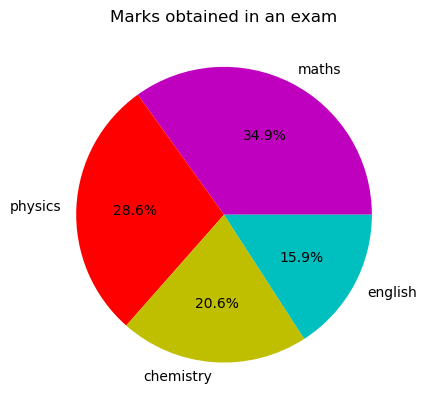

In [12]:
image

### Q&A over image

In [14]:
from transformers import AutoProcessor, TextStreamer

messages = [
    {"role": "user", "content": "<|image_1|>\nPlease create Python code for image, and use plt to save the new picture under imgs/ and name it phi-3-vision.jpg."},
]

processor = AutoProcessor.from_pretrained(llm_model_path, trust_remote_code=True)

prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

inputs = processor(prompt, [image], return_tensors="pt")

generation_args = {"max_new_tokens": 3072, "do_sample": False, "streamer": TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True)}

print("Coding:")
generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

/home2/ethan/intel/openvino_build_deploy/workshops/accelerating_inference_with_openvino_and_pytorch/custom_ai_assistant/openvino_tes/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:513: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


Coding:
Certainly! Below is the Python code to generate a pie chart from the given CSV data and save it as a JPG file named "phi-3-vision.jpg".

```python
import matplotlib.pyplot as plt

# Data
subjects = ['maths', 'physics', 'chemistry', 'english']
marks = [90, 70, 40, 30]

# Create pie chart
fig, ax = plt.subplots()
ax.pie(marks, labels=subjects, autopct='%1.1f%%', startangle=90, colors=['#E600EE', '#FF0000', '#ADFF00', '#00FF00'])

# Set the title of the pie chart
ax.set_title('Marks obtained in an exam')

# Save the figure
plt.savefig('imgs/phi-3-vision.jpg', format='jpg')

# Close the plot to avoid displaying it in an interactive window
plt.close()
```

This code will create a pie chart with the given data, showing the percentage of marks obtained in each subject. The chart will be saved as a JPG file named "phi-3-vision.jpg" in the "imgs" directory.
